# Comparação de Métodos de Geração de Sinais Sintéticos

Este notebook compara dois métodos de geração de sinais de falha em rolamentos:
1. **Método FFT (Soma de Senóides)**: Baseado no espectro de frequências calculado.
2. **Método Impulso (Resposta ao Impulso)**: Baseado na convolução de um trem de impulsos com a resposta estrutural.

O objetivo é visualizar as diferenças no domínio da frequência (FFT) para validar a qualidade dos sinais gerados.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Adicionar src ao path
sys.path.append(os.path.abspath(''))

import segment_and_split_data as ssd
import generate_synthetic_data as gsd
import generate_impulse_data as gid
import bearing_utils as bu

# Configurações
RPM = 1730
FS = 12000

Iniciando a leitura e segmentação dos arquivos em 'c:\Users\Cliente\Documents\GitHub\TCC\data'...
Dados normais serão divididos (80% treino / 20% teste).
Dados de falha real irão 100% para o teste.

--- Processo Concluído! ---
Total de segmentos de TREINO (APENAS 80% normais): 470
Total de segmentos de TESTE (falhas reais + 20% normais): 3184

Exemplo de um segmento de TREINO (chave: '1730_Normal_DE_treino_seg_0'):
   amplitude   arquivo_origem  rotacao_rpm tipo_falha diametro_falha  \
0   0.014603  1730_Normal.npz         1730     Normal            N/A   
1   0.054449  1730_Normal.npz         1730     Normal            N/A   
2   0.107646  1730_Normal.npz         1730     Normal            N/A   
3   0.133722  1730_Normal.npz         1730     Normal            N/A   
4   0.112652  1730_Normal.npz         1730     Normal            N/A   

  local_sensor  
0    Drive End  
1    Drive End  
2    Drive End  
3    Drive End  
4    Drive End  

Exemplo de um segmento de TESTE (chave: '1730

### 1. Carregar Sinal Normal Base
Usaremos um segmento real 'Normal' com 1730 RPM como ruído de fundo base para ambos os métodos.

In [2]:
normal_seg = None
for k, v in ssd.dicionario_treino.items():
    if v['rotacao_rpm'].iloc[0] == RPM:
        normal_seg = v['amplitude'].values
        print(f"Segmento Normal Carregado: {k}")
        break

if normal_seg is None:
    # Fallback
    k = list(ssd.dicionario_treino.keys())[0]
    normal_seg = ssd.dicionario_treino[k]['amplitude'].values
    print(f"Aviso: RPM exato não encontrado. Usando segmento: {k}")

n = len(normal_seg)
duration = n / FS

Segmento Normal Carregado: 1730_Normal_DE_treino_seg_0


### 2. Funções Auxiliares de Plotagem

In [3]:
def plot_comparison(fault_name, sig_fft_comb, sig_impulse_comb, sig_fft_pure, sig_impulse_pure):
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=True)
    
    # Função interna para FFT
    def calc_fft(sig):
        yf = fft(sig)
        xf = fftfreq(len(sig), 1/FS)[:len(sig)//2]
        mag = 2.0/len(sig) * np.abs(yf[0:len(sig)//2])
        return xf, mag

    # Plot 1: Método FFT
    x1_c, y1_c = calc_fft(sig_fft_comb)
    x1_p, y1_p = calc_fft(sig_fft_pure)
    axes[0].plot(x1_c, y1_c, color='#2980b9', alpha=0.7, label='Sinal Combinado (Ruído + Falha)')
    axes[0].plot(x1_p, y1_p, color='#e74c3c', linestyle='--', alpha=0.9, label='Sinal Puro (Apenas Falha)')
    axes[0].set_title(f"{fault_name} - Método FFT (Soma Senóides)", fontsize=12, fontweight='bold')
    axes[0].set_ylabel("Magnitude")
    axes[0].set_xlim(0, 2000)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper right')

    # Plot 2: Método Impulso
    x2_c, y2_c = calc_fft(sig_impulse_comb)
    x2_p, y2_p = calc_fft(sig_impulse_pure)
    axes[1].plot(x2_c, y2_c, color='#2980b9', alpha=0.7, label='Sinal Combinado (Ruído + Falha)')
    axes[1].plot(x2_p, y2_p, color='#e74c3c', linestyle='--', alpha=0.9, label='Sinal Puro (Apenas Falha)')
    axes[1].set_title(f"{fault_name} - Método Impulso (Convolução)", fontsize=12, fontweight='bold')
    axes[1].set_ylabel("Magnitude")
    axes[1].set_xlabel("Frequência (Hz)")
    axes[1].set_xlim(0, 2000)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='upper right')
    
    plt.show()

### 3. Geração e Comparação por Tipo de Falha

In [4]:
# Preparar geração do método de impulso para todos os tipos de uma vez
# CORREÇÃO: Criar DataFrame corretamente para evitar erro de dimensão
df_dummy = pd.DataFrame({'amplitude': normal_seg})
df_dummy['rotacao_rpm'] = RPM
df_dummy['tipo_falha'] = 'Normal'

dummy_dict = {'temp_normal': df_dummy}

print("Gerando sinais pelo método de Impulso...")
# Usamos multiplicador maior para visualizar bem o impacto
df_impulse = gid.gerar_dados_sinteticos_treino(
    dicionario_treino=dummy_dict,
    TAXA_AMOSTRAL=FS,
    params_drive_end=gid.params_drive_end,
    amplitudes_referencia=gid.amplitudes_referencia,
    multiplicadores=[1], # Amplitude x1 (Realista)
    fases_para_adicionar_rad=[0]
)

Gerando sinais pelo método de Impulso...
Usando 999 modos naturais para Outer Race (primeiro: 5037.1 Hz)
Usando 999 modos naturais para Inner Race (primeiro: 14142.8 Hz)
Gerando Sinais... (damp=0.1, dur=0.1s, mod=0.5)
Geração concluída. Total de 4 segmentos de treino.


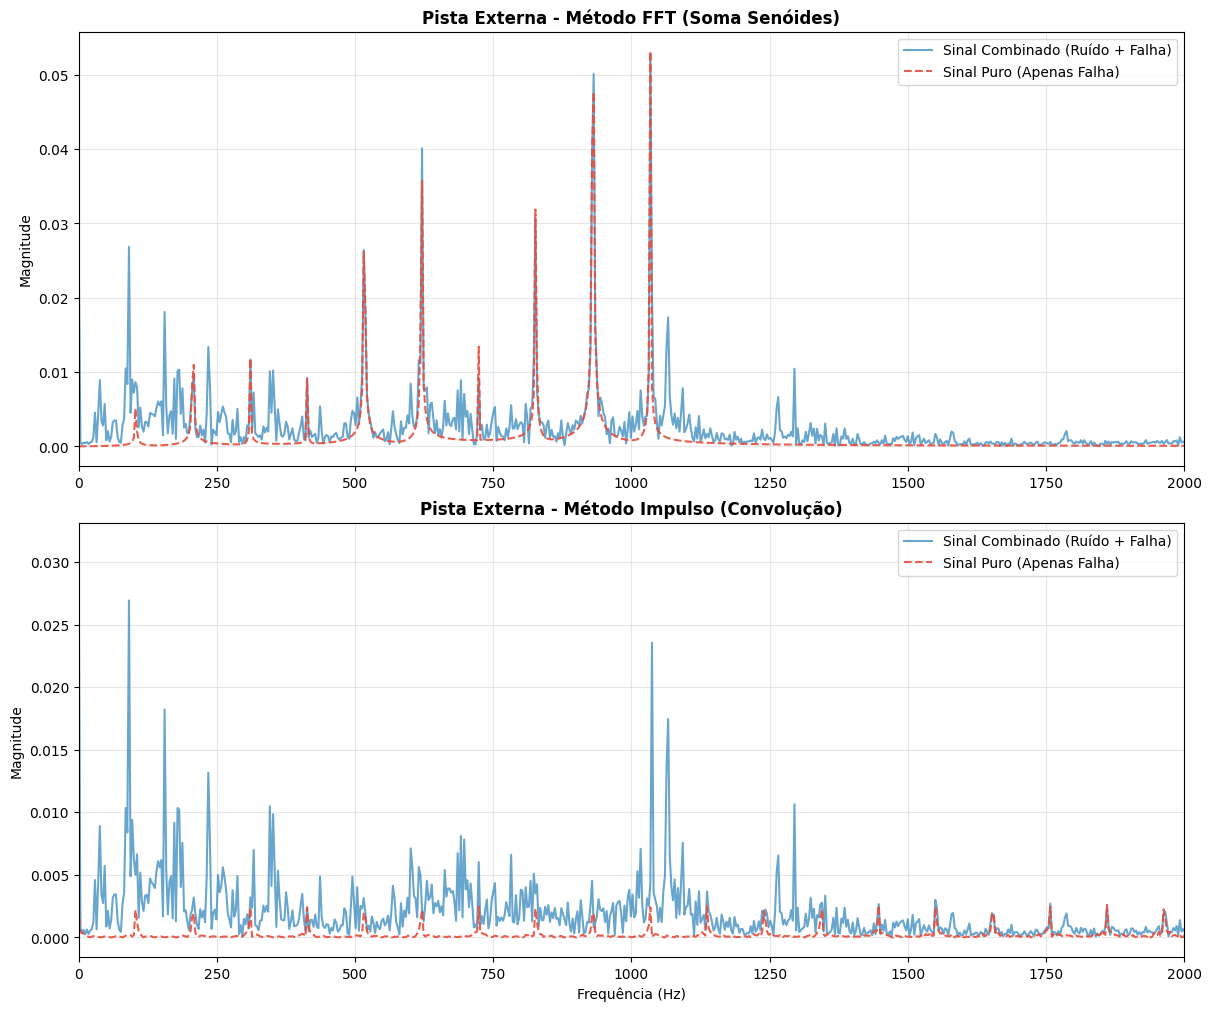

In [5]:
# --- Pista Externa ---

# 1. Gerar FFT Method
spec_outer = bu.calcular_espectro_outer_race(fault_diameter_mm=0.5, rpm=RPM, K=0.008) # Ajuste K para ficar comparável se necessário
sig_outer_gen = gsd.synthesize_time_signal(spec_outer, duration=duration, fs=FS)
# Ajuste de tamanho
sig_outer_gen = sig_outer_gen[:n] if len(sig_outer_gen) > n else np.pad(sig_outer_gen, (0, n - len(sig_outer_gen)))
final_outer_fft = normal_seg + sig_outer_gen

# 2. Pegar Impulse Method
row_outer = df_impulse[df_impulse['tipo_falha_adicionada'] == 'Pista Externa'].iloc[0]
final_outer_imp = row_outer['sinal_final']
final_outer_imp_pure = row_outer['sinal_puro']

plot_comparison("Pista Externa", final_outer_fft, final_outer_imp, sig_outer_gen, final_outer_imp_pure)

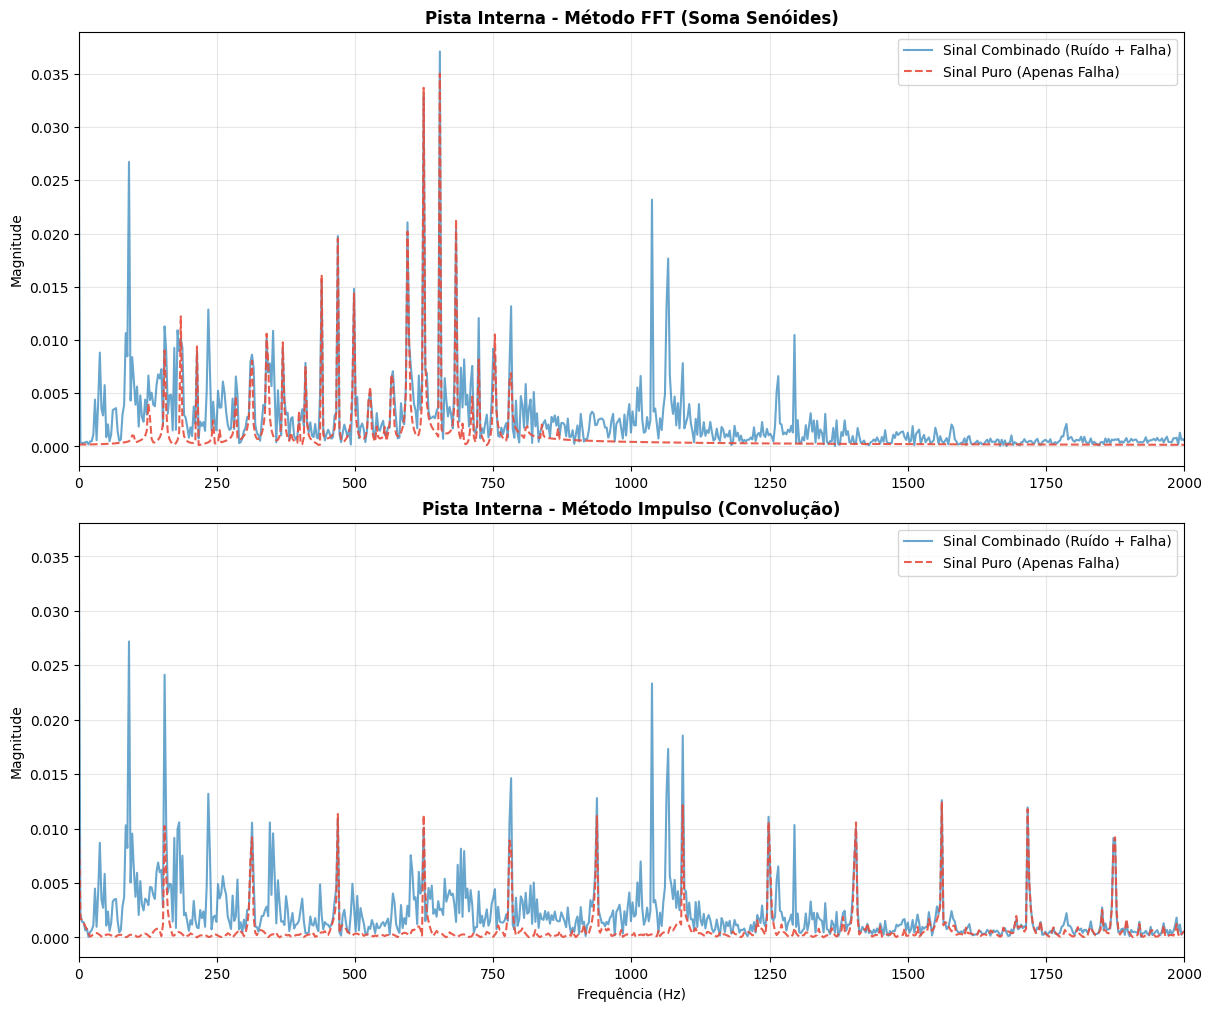

In [6]:
# --- Pista Interna ---

# 1. Gerar FFT Method
spec_inner = bu.calcular_espectro_inner_completo(fault_diameter_mm=0.5, rpm=RPM, K=0.1)
sig_inner_gen = gsd.synthesize_time_signal(spec_inner, duration=duration, fs=FS)
sig_inner_gen = sig_inner_gen[:n] if len(sig_inner_gen) > n else np.pad(sig_inner_gen, (0, n - len(sig_inner_gen)))
final_inner_fft = normal_seg + sig_inner_gen

# 2. Pegar Impulse Method
row_inner = df_impulse[df_impulse['tipo_falha_adicionada'] == 'Pista Interna'].iloc[0]
final_inner_imp = row_inner['sinal_final']
final_inner_imp_pure = row_inner['sinal_puro']

plot_comparison("Pista Interna", final_inner_fft, final_inner_imp, sig_inner_gen, final_inner_imp_pure)

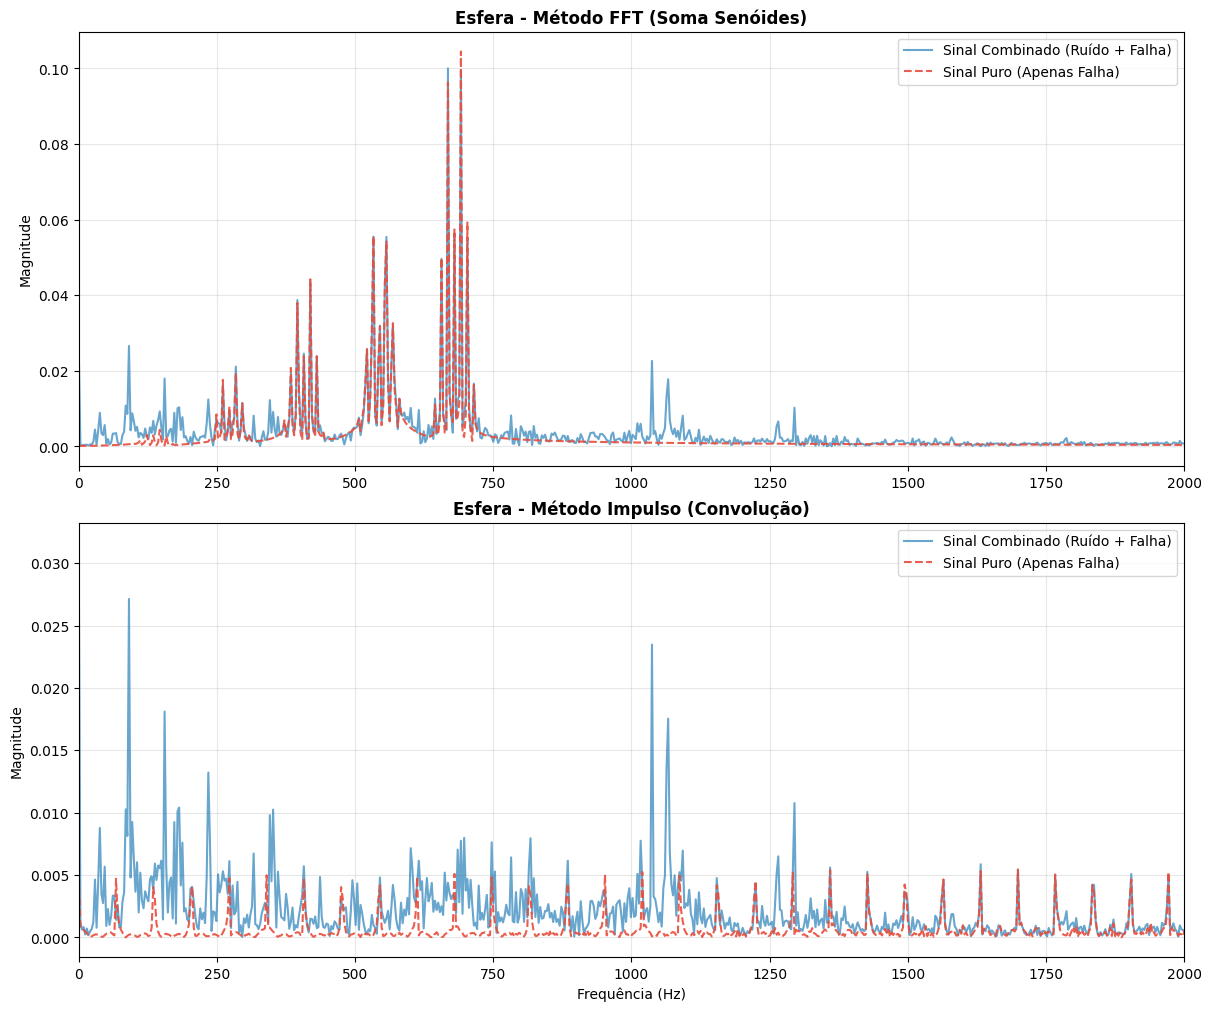

In [7]:
# --- Esfera ---

# 1. Gerar FFT Method
spec_ball = bu.calcular_espectro_ball_completo(fault_diameter_mm=0.5, rpm=RPM, K=0.05)
sig_ball_gen = gsd.synthesize_time_signal(spec_ball, duration=duration, fs=FS)
sig_ball_gen = sig_ball_gen[:n] if len(sig_ball_gen) > n else np.pad(sig_ball_gen, (0, n - len(sig_ball_gen)))
final_ball_fft = normal_seg + sig_ball_gen

# 2. Pegar Impulse Method
row_ball = df_impulse[df_impulse['tipo_falha_adicionada'] == 'Esfera'].iloc[0]
final_ball_imp = row_ball['sinal_final']
final_ball_imp_pure = row_ball['sinal_puro']

plot_comparison("Esfera", final_ball_fft, final_ball_imp, sig_ball_gen, final_ball_imp_pure)